In [1]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [2]:
VERSION = 48
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 2
NO_BLACK_LOSS = True

In [3]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [4]:
all_black = '006d4432e'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [5]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_cat + cols_float

In [7]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [8]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [9]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [10]:
if DATA_SET == 1:
    feat_sz = 2208
elif DATA_SET == 2:
    feat_sz = 208
else: assert False

In [11]:
if DATA_SET == 2:
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/densenet169_v3/train/train.ids.df','wb'))

        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

        pickle.dump(test_md, open(PATH_WORK/'features/densenet169_v3/test/test.ids.df','wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_Densenet169_3_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(fold)
            feats = pickle.load(open(filename,'rb'))
            assert len(feats) == 4*len(ids_df)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/densenet169_v3/train/train.f{}.a{}'
                                             .format(fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/densenet169_v3/train/valid.f{}.a{}'
                                             .format(fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/densenet169_v3/train/black.f{}'
                                                  .format(fold),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_Densenet169_3_version_classifier_splits_type_features_test_split_{}.pkl'\
                .format(fold)
            feats = pickle.load(open(filename,'rb'))

            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/densenet169_v3/test/test.f{}.a{}'
                                            .format(fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/densenet169_v3/train/train.ids.df','rb'))
        test_md = pickle.load(open(PATH_WORK/'features/densenet169_v3/test/test.ids.df','rb'))

In [12]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [13]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [14]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [15]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset == 2:
            path = PATH_WORK/'features/densenet169_v3/train/black.f{}'.format(fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
            
            if mode == 'valid':
                self.setFeats(0)
            
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        def getAPath(an):
            return PATH_WORK/'features/densenet169_v3/{}/{}.f{}.a{}'.format(folder,self.mode,self.fold,an)
        
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        sz = len(self.metadata)
        if anum == -1:
            max_a = 8 if self.mode == 'test' else 4
            feats2 = torch.stack([pickle.load(open(getAPath(an),'rb')) for an in range(max_a)])
            feats = feats2[torch.randint(max_a,(sz,)), torch.arange(sz)].squeeze()
        else:
            feats = pickle.load(open(getAPath(anum),'rb'))
        
        self.feats = feats
        assert len(feats) == sz
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset == 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx.values)
        df = df.sort_values(['pos_idx'])
        feats = feats[torch.LongTensor(order)]
        
        non_black = torch.ones(len(feats))
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        target = torch.Tensor(df[all_ich].values)
        
        PAD = 4+9+1
        #PAD = 3
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            if offset > 0:
                non_black = torch.cat([torch.zeros(offset), non_black])
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            if (60 - len(df) - offset) > 0:
                non_black = torch.cat([non_black, torch.zeros(60 - len(df) - offset)])
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, target, non_black
        else:
            return feats, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [16]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [17]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()

In [18]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [19]:
act_fun = nn.ReLU(inplace=True)

def conv_layer(ni, nf, ks=3, act=True):
    bn = nn.BatchNorm1d(nf)
    layers = [nn.Conv1d(ni, nf, ks), bn]
    if act: layers.append(act_fun)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        layers  = [conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, act=False)]
        self.convs = nn.Sequential(*layers)

    def forward(self, x): return act_fun(self.convs(x) + x[:,:,1:-1])

In [20]:
class ResNetModel(nn.Module):
    def __init__(self, n_cont:int, feat_sz=2208):
        super().__init__()
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        
        self.conv2D = nn.Conv2d(1,64,(feat_sz + n_cont,1))
        
        self.res1 = ResBlock(64,64)
        self.res2 = ResBlock(64,64)
        self.res3 = ResBlock(64,64)
        
        self.conv1D = nn.Conv1d(64,6,1)
    
    def forward(self, x) -> torch.Tensor:
        x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        
        x = self.conv2D(x).squeeze()
        x = act_fun(x)
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        
        x = self.conv1D(x)
        x = x.transpose(1,2)
        return x

In [21]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        #self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,64,(feat_sz + n_cont,1))
        self.conv2D_2 = nn.Conv2d(1,64,(feat_sz + n_cont,5))#,padding=(0,2)
        self.bn_cont1 = nn.BatchNorm1d(128)
        self.conv1D_1 = nn.Conv1d(128,64,3)#,padding=1
        self.conv1D_3 = nn.Conv1d(128,64,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(128,6,3)#,padding=1
        self.bn_cont2 = nn.BatchNorm1d(128)
        self.bn_cont3 = nn.BatchNorm1d(6)

        self.conv1D_4 = nn.Conv1d(128,128,3)
        self.bn_cont4 = nn.BatchNorm1d(128)

    def forward(self, x) -> torch.Tensor:
        x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1) # bs,2208,60
        x = self.fc_drop(x)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        #x = self.conv1D_1(x)
        
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]), 
                       self.conv1D_3(x)], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        
        x = self.conv1D_4(x)
        x = self.relu(x)
        x = self.bn_cont4(x)
        
        x = self.conv1D_2(x)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [22]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    for i, (x, y, non_black) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            y = y.to(device)
            non_black = non_black.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x)
        
        if MIXUP:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, lambd*non_black[:,:,None]) \
                     + criterion(output, y_mix, (1-lambd)*non_black[:,:,None])
            else:
                loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd)
            del x_mix, y_mix
        else:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, non_black[:,:,None])
            else:
                loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x
    
    return tloss, tloss_count

In [23]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [24]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [25]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET == 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    #model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()
    #if DATA_SET == 1:
    #    loc_data = val_data.copy()
    #else:
    #    loc_data = ids_df.loc[ids_df.fold == fold].copy().reset_index(drop=True)

    if DATA_SMALL:
        #val_sz = int(0.01*len(loc_data.index.unique()))
        val_sz = len(val_ds)
        val_series = val_ds.series[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        #trn_ds.setFeats((i-1) % 4)
        trn_ds.setFeats(-1)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, auc, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [26]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [27]:
# 3x0.002, 3x0.001, 3x0.0002
# back to orig
# ver 48, epoch 9,  fold 0, train ll: 0.0300, val ll: 0.0677, cor: 0.8405, auc: 0.9839, lr: 0.0002
# ver 48, epoch 14, fold 0, train ll: 0.0297, val ll: 0.0688, cor: 0.8391, auc: 0.9837, lr: 0.0002

# resnet
# 3x0.002, 3x0.001, 3x0.0002
# ver 47, epoch 9, fold 0, train ll: 0.0299, val ll: 0.0677, cor: 0.8359, auc: 0.9857, lr: 0.0002

# relu and bn switched places
# ver 44, epoch 21, fold 0, train ll: 0.0326, val ll: 0.0667, cor: 0.8361, auc: 0.9867, lr: 0.0002
# all doubled size
# ver 43, epoch 21, fold 0, train ll: 0.0313, val ll: 0.0656, cor: 0.8403, auc: 0.9858, lr: 0.0002
# +layer
# ver 42, epoch 21, fold 0, train ll: 0.0315, val ll: 0.0654, cor: 0.8403, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 7x0.0002
# ver 41, epoch 21, fold 2, train ll: 0.0321, val ll: 0.0630, cor: 0.8400, auc: 0.9878, lr: 0.0002
# ver 41, epoch 21, fold 1, train ll: 0.0317, val ll: 0.0652, cor: 0.8370, auc: 0.9863, lr: 0.0002
# ver 41, epoch 21, fold 0, train ll: 0.0310, val ll: 0.0654, cor: 0.8407, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 3x0.0002
# mixing aug
# ver 41, epoch 17, fold 0, train ll: 0.0308, val ll: 0.0657, cor: 0.8406, auc: 0.9862, lr: 0.0002
# no bn for feats
# ver 40, epoch 14, fold 0, train ll: 0.0315, val ll: 0.0663, cor: 0.8400, auc: 0.9859, lr: 0.0002

# mixup
# ver 39, epoch 21, fold 1, train ll: 0.0496, val ll: 0.0688, cor: 0.8318, auc: 0.9859, lr: 0.0002

# no dropout
# ver 39, epoch 14, fold 1, train ll: 0.0335, val ll: 0.0663, cor: 0.8335, auc: 0.9852, lr: 0.0002
# ver 39, epoch 17, fold 0, train ll: 0.0322, val ll: 0.0680, cor: 0.8369, auc: 0.9843, lr: 0.0002
# bs=32, no black
# ver 39, epoch 14, fold 0, train ll: 0.0354, val ll: 0.0689, cor: 0.8351, auc: 0.9830, lr: 0.0002

# bs=16
# ver 38, epoch 14, fold 0, train ll: 0.0365, val ll: 0.0694, cor: 0.8330, lr: 0.0002
# ver 38, epoch 17, fold 0, train ll: 0.0362, val ll: 0.0684, cor: 0.8346, lr: 0.0001

# back to 64, dropped dilated
# ver 37, epoch 14, fold 2, train ll: 0.0367, val ll: 0.0641, cor: 0.8360, lr: 0.0002
# ver 37, epoch 14, fold 1, train ll: 0.0374, val ll: 0.0665, cor: 0.8324, lr: 0.0002
# ver 37, epoch 14, fold 0, train ll: 0.0360, val ll: 0.0676, cor: 0.8346, lr: 0.0002

# 3x0.0001
# ver 36, epoch 17, fold 2, train ll: 0.0364, val ll: 0.0646, cor: 0.8367
# ver 36, epoch 16, fold 1, train ll: 0.0375, val ll: 0.0663, cor: 0.8326
# ver 36, epoch 17, fold 0, train ll: 0.0358, val ll: 0.0677, cor: 0.8357

# 7x0.02, 4x0.002, 3x0.0002
# bs = 32
# ver 36, epoch 14, fold 2, train ll: 0.0366, val ll: 0.0647, cor: 0.8362
# ver 36, epoch 13, fold 1, train ll: 0.0379, val ll: 0.0663, cor: 0.8327
# ver 36, epoch 14, fold 0, train ll: 0.0359, val ll: 0.0674, cor: 0.8354

# 10x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 34, epoch 19, train ll: 0.0363, val ll: 0.0675, cor: 0.8347

#--- dataset 2

# 13x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 32, epoch 22, train ll: 0.0375, val ll: 0.0582, cor: 0.8480

#--- dataset 1

# 10x0.02, 8x0.002, 3x0.0002
# with augmentations
# ver 31, epoch 21, train ll: 0.0866, val ll: 0.1533, cor: 0.5319

# 10x0.02, 6x0.002, 3x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# ver 26, epoch 19, train ll: 0.0867, val ll: 0.1531, cor: 0.5305

#--- dataset 2

# 10x0.02, 3x0.002, 6x0.0002 (+10x0.0002)
# back to orig best
# epoch 19, train ll: 0.0389, val ll: 0.0602, cor: 0.8424
# epoch 29, train ll: 0.0378, val ll: 0.0593, cor: 0.8448

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# reduced all sizes
# epoch 17, train ll: 0.0407, val ll: 0.0620, cor: 0.8371

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# epoch 17, train ll: 0.0379, val ll: 0.0589, cor: 0.8460

# 3x0.1, 5x0.02, 3x0.002, 6x0.0002
# dilated, 3xTTA
# epoch 17, train ll: 0.0364, val ll: 0.0582, cor: 0.8454, LB 0.066

# train ll: 0.0354, val ll: 0.0577, cor: 0.8462, LB 0.065

In [28]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# normalize metadata outliers
# try GCP fast guide connecting
# 32 TTA
# no auc

# Yuval: zoom in, squish, perspective wraping

In [29]:
DATA_SMALL = False
weight_decay = 1e-3
f = 0
learning_rate = 0.002
model, predictions = train_one(epochs=3, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=3, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=3, bs=bs, fold=f)

completed epochs: 0 starting now: 3
DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 8.123 time per batch: 2.031
Batch 8 device: xla:1 time passed: 11.377 time per batch: 1.422
Batch 12 device: xla:1 time passed: 16.229 time per batch: 1.352
Batch 16 device: xla:1 time passed: 20.920 time per batch: 1.307
Batch 20 device: xla:1 time passed: 25.748 time per batch: 1.287
Batch 24 device: xla:1 time passed: 30.545 time per batch: 1.273
Batch 28 device: xla:1 time passed: 35.226 time per batch: 1.258
Batch 32 device: xla:1 time passed: 40.151 time per batch: 1.255
Batch 36 device: xla:1 time passed: 44.882 time per batch: 1.247
Batch 40 device: xla:1 time passed: 49.752 time per batch: 1.244
Batch 44 device: xla:1 time passed: 54.560 time per batch: 1.240
Batch 48 device: xla:1 t

DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
loading model model.b6.f0.v48
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.710 time per batch: 1.678
Batch 8 device: xla:1 time passed: 11.049 time per batch: 1.381
Batch 12 device: xla:1 time passed: 15.915 time per batch: 1.326
Batch 16 device: xla:1 time passed: 20.791 time per batch: 1.299
Batch 20 device: xla:1 time passed: 25.610 time per batch: 1.280
Batch 24 device: xla:1 time passed: 30.377 time per batch: 1.266
Batch 28 device: xla:1 time passed: 35.230 time per batch: 1.258
Batch 32 device: xla:1 time passed: 40.009 time per batch: 1.250
Batch 36 device: xla:1 time passed: 44.957 time per batch: 1.249
Batch 40 device: xla:1 time passed: 49.692 time per batch: 1.242
Batch 44 device: xla:1 time passed: 54.498 time per batch: 1.239
Batch 48 device: xla:1 time passed: 59.232 time per 

In [30]:
learning_rate = 0.0002
model, predictions = train_one(epochs=10, bs=bs, fold=f)

completed epochs: 9 starting now: 10
DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
loading model model.b9.f0.v48
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.622 time per batch: 1.655
Batch 8 device: xla:1 time passed: 11.069 time per batch: 1.384
Batch 12 device: xla:1 time passed: 15.978 time per batch: 1.331
Batch 16 device: xla:1 time passed: 20.805 time per batch: 1.300
Batch 20 device: xla:1 time passed: 25.607 time per batch: 1.280
Batch 24 device: xla:1 time passed: 30.546 time per batch: 1.273
Batch 28 device: xla:1 time passed: 35.469 time per batch: 1.267
Batch 32 device: xla:1 time passed: 40.220 time per batch: 1.257
Batch 36 device: xla:1 time passed: 45.107 time per batch: 1.253
Batch 40 device: xla:1 time passed: 49.833 time per batch: 1.246
Batch 44 device: xla:1 time passed: 54.682 time per batch: 1.243
Batch 48 device

KeyboardInterrupt: 

In [55]:
DATA_SMALL = False
weight_decay = 1e-3
f = 0
learning_rate = 0.0002
model, predictions = train_one(epochs=4, bs=bs, fold=f)

completed epochs: 17 starting now: 4
DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
loading model model.b17.f0.v41
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.895 time per batch: 1.724
Batch 8 device: xla:1 time passed: 11.337 time per batch: 1.417
Batch 12 device: xla:1 time passed: 16.121 time per batch: 1.343
Batch 16 device: xla:1 time passed: 20.929 time per batch: 1.308
Batch 20 device: xla:1 time passed: 25.826 time per batch: 1.291
Batch 24 device: xla:1 time passed: 30.533 time per batch: 1.272
Batch 28 device: xla:1 time passed: 35.431 time per batch: 1.265
Batch 32 device: xla:1 time passed: 40.439 time per batch: 1.264
Batch 36 device: xla:1 time passed: 45.007 time per batch: 1.250
Batch 40 device: xla:1 time passed: 49.846 time per batch: 1.246
Batch 44 device: xla:1 time passed: 54.633 time per batch: 1.242
Batch 48 devic

In [56]:
DATA_SMALL = False
weight_decay = 1e-3
f = 1
learning_rate = 0.02
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 2 train size 12982 fold 1
adding dummy serieses 108
DataSet 2 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.813 time per batch: 1.703
Batch 8 device: xla:1 time passed: 11.208 time per batch: 1.401
Batch 12 device: xla:1 time passed: 15.974 time per batch: 1.331
Batch 16 device: xla:1 time passed: 20.743 time per batch: 1.296
Batch 20 device: xla:1 time passed: 25.569 time per batch: 1.278
Batch 24 device: xla:1 time passed: 30.331 time per batch: 1.264
Batch 28 device: xla:1 time passed: 35.067 time per batch: 1.252
Batch 32 device: xla:1 time passed: 39.972 time per batch: 1.249
Batch 36 device: xla:1 time passed: 44.643 time per batch: 1.240
Batch 40 device: xla:1 time passed: 49.492 time per batch: 1.237
Batch 44 device: xla:1 time passed: 54.187 time per batch: 1.232
Batch 48 device: xla:1 t

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 41, epoch 3, fold 1, train ll: 0.0421, val ll: inf, cor: 0.6612, auc: 0.9564, lr: 0.02
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.790 time per batch: 1.697
Batch 8 device: xla:1 time passed: 11.168 time per batch: 1.396
Batch 12 device: xla:1 time passed: 16.003 time per batch: 1.334
Batch 16 device: xla:1 time passed: 20.775 time per batch: 1.298
Batch 20 device: xla:1 time passed: 25.571 time per batch: 1.279
Batch 24 device: xla:1 time passed: 30.403 time per batch: 1.267
Batch 28 device: xla:1 time passed: 35.223 time per batch: 1.258
Batch 32 device: xla:1 time passed: 40.018 time per batch: 1.251
Batch 36 device: xla:1 time passed: 44.797 time per batch: 1.244
Batch 40 device: xla:1 time passed: 49.639 time per batch: 1.241
Batch 44 device: xla:1 time passed: 54.449 time per batch: 1.237
Batch 48 device: xla:1 time passed: 59.207 time per batch: 1.233
Batch 4 device: xla:1 time passed: 4.893 time per batch: 1.223
Batch 8 device: xla:1 time passed: 7.430 ti

Batch 12 device: xla:1 time passed: 16.156 time per batch: 1.346
Batch 16 device: xla:1 time passed: 21.077 time per batch: 1.317
Batch 20 device: xla:1 time passed: 25.899 time per batch: 1.295
Batch 24 device: xla:1 time passed: 30.750 time per batch: 1.281
Batch 28 device: xla:1 time passed: 35.611 time per batch: 1.272
Batch 32 device: xla:1 time passed: 40.484 time per batch: 1.265
Batch 36 device: xla:1 time passed: 45.367 time per batch: 1.260
Batch 40 device: xla:1 time passed: 50.138 time per batch: 1.253
Batch 44 device: xla:1 time passed: 55.012 time per batch: 1.250
Batch 48 device: xla:1 time passed: 59.836 time per batch: 1.247
Batch 4 device: xla:1 time passed: 4.935 time per batch: 1.234
Batch 8 device: xla:1 time passed: 7.538 time per batch: 0.942
Batch 12 device: xla:1 time passed: 10.547 time per batch: 0.879
Batch 16 device: xla:1 time passed: 13.494 time per batch: 0.843
Batch 20 device: xla:1 time passed: 16.514 time per batch: 0.826
Batch 24 device: xla:1 time p

Batch 28 device: xla:1 time passed: 35.524 time per batch: 1.269
Batch 32 device: xla:1 time passed: 40.305 time per batch: 1.260
Batch 36 device: xla:1 time passed: 45.188 time per batch: 1.255
Batch 40 device: xla:1 time passed: 50.052 time per batch: 1.251
Batch 44 device: xla:1 time passed: 54.794 time per batch: 1.245
Batch 48 device: xla:1 time passed: 59.648 time per batch: 1.243
Batch 4 device: xla:1 time passed: 4.997 time per batch: 1.249
Batch 8 device: xla:1 time passed: 7.467 time per batch: 0.933
Batch 12 device: xla:1 time passed: 10.479 time per batch: 0.873
Batch 16 device: xla:1 time passed: 13.458 time per batch: 0.841
Batch 20 device: xla:1 time passed: 16.476 time per batch: 0.824
Batch 24 device: xla:1 time passed: 19.452 time per batch: 0.810
ver 41, epoch 16, fold 1, train ll: 0.0320, val ll: 0.0653, cor: 0.8370, auc: 0.9863, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.872 time per batch: 1.718
Batch 8 device: xla:1 time passed: 11.

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 41, epoch 19, fold 1, train ll: 0.0316, val ll: nan, cor: 0.8356, auc: 0.9862, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.039 time per batch: 1.760
Batch 8 device: xla:1 time passed: 11.320 time per batch: 1.415
Batch 12 device: xla:1 time passed: 16.206 time per batch: 1.350
Batch 16 device: xla:1 time passed: 20.976 time per batch: 1.311
Batch 20 device: xla:1 time passed: 25.872 time per batch: 1.294
Batch 24 device: xla:1 time passed: 30.691 time per batch: 1.279
Batch 28 device: xla:1 time passed: 35.496 time per batch: 1.268
Batch 32 device: xla:1 time passed: 40.327 time per batch: 1.260
Batch 36 device: xla:1 time passed: 45.216 time per batch: 1.256
Batch 40 device: xla:1 time passed: 50.132 time per batch: 1.253
Batch 44 device: xla:1 time passed: 55.027 time per batch: 1.251
Batch 48 device: xla:1 time passed: 59.859 time per batch: 1.247
Batch 4 device: xla:1 time passed: 4.964 time per batch: 1.241
Batch 8 device: xla:1 time passed: 7.508

In [57]:
DATA_SMALL = False
weight_decay = 1e-3
f = 2
learning_rate = 0.02
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 2 train size 13036 fold 2
adding dummy serieses 162
DataSet 2 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.904 time per batch: 1.726
Batch 8 device: xla:1 time passed: 11.397 time per batch: 1.425
Batch 12 device: xla:1 time passed: 16.097 time per batch: 1.341
Batch 16 device: xla:1 time passed: 20.853 time per batch: 1.303
Batch 20 device: xla:1 time passed: 25.605 time per batch: 1.280
Batch 24 device: xla:1 time passed: 30.413 time per batch: 1.267
Batch 28 device: xla:1 time passed: 35.152 time per batch: 1.255
Batch 32 device: xla:1 time passed: 40.007 time per batch: 1.250
Batch 36 device: xla:1 time passed: 44.855 time per batch: 1.246
Batch 40 device: xla:1 time passed: 49.608 time per batch: 1.240
Batch 44 device: xla:1 time passed: 54.433 time per batch: 1.237
Batch 48 device: xla:1 t

Batch 20 device: xla:1 time passed: 25.608 time per batch: 1.280
Batch 24 device: xla:1 time passed: 30.465 time per batch: 1.269
Batch 28 device: xla:1 time passed: 35.217 time per batch: 1.258
Batch 32 device: xla:1 time passed: 40.031 time per batch: 1.251
Batch 36 device: xla:1 time passed: 44.815 time per batch: 1.245
Batch 40 device: xla:1 time passed: 49.615 time per batch: 1.240
Batch 44 device: xla:1 time passed: 54.376 time per batch: 1.236
Batch 48 device: xla:1 time passed: 59.214 time per batch: 1.234
Batch 4 device: xla:1 time passed: 4.878 time per batch: 1.219
Batch 8 device: xla:1 time passed: 7.579 time per batch: 0.947
Batch 12 device: xla:1 time passed: 10.585 time per batch: 0.882
Batch 16 device: xla:1 time passed: 13.484 time per batch: 0.843
Batch 20 device: xla:1 time passed: 16.480 time per batch: 0.824
Batch 24 device: xla:1 time passed: 19.457 time per batch: 0.811
ver 41, epoch 7, fold 2, train ll: 0.0439, val ll: 0.0817, cor: 0.7922, auc: 0.9830, lr: 0.02


Batch 36 device: xla:1 time passed: 45.305 time per batch: 1.258
Batch 40 device: xla:1 time passed: 50.027 time per batch: 1.251
Batch 44 device: xla:1 time passed: 54.736 time per batch: 1.244
Batch 48 device: xla:1 time passed: 59.494 time per batch: 1.239
Batch 4 device: xla:1 time passed: 5.459 time per batch: 1.365
Batch 8 device: xla:1 time passed: 8.113 time per batch: 1.014
Batch 12 device: xla:1 time passed: 11.431 time per batch: 0.953
Batch 16 device: xla:1 time passed: 14.405 time per batch: 0.900
Batch 20 device: xla:1 time passed: 17.384 time per batch: 0.869
Batch 24 device: xla:1 time passed: 20.228 time per batch: 0.843
ver 41, epoch 13, fold 2, train ll: 0.0329, val ll: 0.0649, cor: 0.8374, auc: 0.9870, lr: 0.002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.884 time per batch: 1.721
Batch 8 device: xla:1 time passed: 11.331 time per batch: 1.416
Batch 12 device: xla:1 time passed: 16.049 time per batch: 1.337
Batch 16 device: xla:1 time passed: 20.8

Batch 48 device: xla:1 time passed: 59.396 time per batch: 1.237
Batch 4 device: xla:1 time passed: 5.040 time per batch: 1.260
Batch 8 device: xla:1 time passed: 7.474 time per batch: 0.934
Batch 12 device: xla:1 time passed: 10.571 time per batch: 0.881
Batch 16 device: xla:1 time passed: 13.556 time per batch: 0.847
Batch 20 device: xla:1 time passed: 16.616 time per batch: 0.831
Batch 24 device: xla:1 time passed: 19.615 time per batch: 0.817
ver 41, epoch 19, fold 2, train ll: 0.0318, val ll: 0.0631, cor: 0.8399, auc: 0.9877, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.045 time per batch: 1.761
Batch 8 device: xla:1 time passed: 11.292 time per batch: 1.411
Batch 12 device: xla:1 time passed: 16.177 time per batch: 1.348
Batch 16 device: xla:1 time passed: 20.908 time per batch: 1.307
Batch 20 device: xla:1 time passed: 25.742 time per batch: 1.287
Batch 24 device: xla:1 time passed: 30.415 time per batch: 1.267
Batch 28 device: xla:1 time passed: 35.

In [52]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.495845,0.222767,0.262498,0.372876,0.077706,0.184072,0.147871,0.184957,0.219007,13042,7200,100,80.560221,140.067585,0.0200,0.001
1,2,0,0.139651,0.212226,0.341014,0.371492,0.032217,0.182368,0.141474,0.176040,0.210502,13042,7200,100,80.586969,143.552010,0.0200,0.001
2,3,0,0.116839,0.206248,0.416058,0.357151,0.030161,0.177022,0.138181,0.175438,0.208632,13042,7200,100,81.362263,142.334380,0.0200,0.001
3,4,0,0.100432,0.248836,0.337192,0.446849,0.031468,0.198398,0.151840,0.208802,0.257649,13042,7200,100,80.487220,142.352772,0.0200,0.001
4,5,0,0.101299,0.198162,0.448064,0.339129,0.027744,0.173676,0.136346,0.179236,0.191874,13042,7200,100,84.477289,146.857369,0.0200,0.001
5,6,0,0.097309,0.190345,0.473876,0.327777,0.027687,0.166361,0.123394,0.165293,0.194129,13042,7200,100,81.727369,143.910612,0.0200,0.001
6,7,0,0.095991,0.179739,0.478224,0.308505,0.027745,0.164267,0.121925,0.155056,0.172170,13042,7200,100,81.609755,140.314667,0.0200,0.001
7,8,0,0.105157,0.162818,0.491558,0.280636,0.027615,0.150090,0.105528,0.135659,0.159565,13042,7200,100,81.324294,141.004881,0.0200,0.001
8,9,0,0.101255,0.182301,0.492721,0.322835,0.027490,0.159502,0.115876,0.152459,0.175106,13042,7200,100,81.279920,140.633701,0.0200,0.001
9,10,0,0.103850,0.161570,0.499187,0.276134,0.029684,0.149958,0.109171,0.133094,0.156818,13042,7200,100,81.465451,142.004258,0.0200,0.001


In [41]:
predictions.mean((0,1))

array([0.08180776, 0.00407849, 0.02802897, 0.02118001, 0.0283712 ,
       0.03698493], dtype=float32)

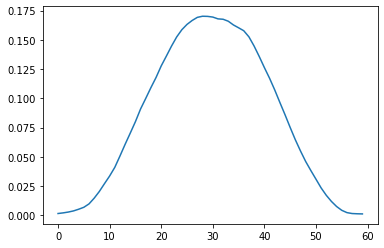

In [42]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [34]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + add_seed)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(anum)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [32]:
VERSION = 36

In [35]:
preds = []
for fold in range(3):
    preds2 = []
    for anum in range(32):
        predictions = inference_one(fold = fold, anum = -1)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)

completed epochs: 17
loading model model.b17.f0.v36


RuntimeError: Error(s) in loading state_dict for TabularModel:
	Missing key(s) in state_dict: "conv1D_4.weight", "conv1D_4.bias", "bn_cont4.weight", "bn_cont4.bias", "bn_cont4.running_mean", "bn_cont4.running_var". 
	Unexpected key(s) in state_dict: "layers.0.weight", "layers.0.bias", "layers.2.weight", "layers.2.bias", "layers.2.running_mean", "layers.2.running_var", "layers.2.num_batches_tracked", "layers.4.weight", "layers.4.bias", "layers.6.weight", "layers.6.bias", "layers.6.running_mean", "layers.6.running_var", "layers.6.num_batches_tracked", "layers.8.weight", "layers.8.bias", "layers.9.weight", "layers.9.bias", "layers.9.running_mean", "layers.9.running_var", "layers.9.num_batches_tracked", "feat_product.weight", "feat_product.bias". 
	size mismatch for bn_cont.weight: copying a param with shape torch.Size([234]) from checkpoint, the shape in current model is torch.Size([26]).
	size mismatch for bn_cont.bias: copying a param with shape torch.Size([234]) from checkpoint, the shape in current model is torch.Size([26]).
	size mismatch for bn_cont.running_mean: copying a param with shape torch.Size([234]) from checkpoint, the shape in current model is torch.Size([26]).
	size mismatch for bn_cont.running_var: copying a param with shape torch.Size([234]) from checkpoint, the shape in current model is torch.Size([26]).
	size mismatch for conv2D_1.weight: copying a param with shape torch.Size([32, 1, 234, 1]) from checkpoint, the shape in current model is torch.Size([64, 1, 234, 1]).
	size mismatch for conv2D_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv2D_2.weight: copying a param with shape torch.Size([32, 1, 234, 5]) from checkpoint, the shape in current model is torch.Size([64, 1, 234, 5]).
	size mismatch for conv2D_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn_cont1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for conv1D_1.weight: copying a param with shape torch.Size([32, 64, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3]).
	size mismatch for conv1D_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv1D_3.weight: copying a param with shape torch.Size([32, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 128, 5]).
	size mismatch for conv1D_3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv1D_2.weight: copying a param with shape torch.Size([6, 64, 3]) from checkpoint, the shape in current model is torch.Size([6, 128, 3]).
	size mismatch for bn_cont2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn_cont2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [60]:
predictions = preds.mean((0,1))

In [61]:
predictions.mean(0)

array([0.12798429, 0.00705347, 0.0445285 , 0.03133041, 0.04695834,
       0.05724061], dtype=float32)

In [65]:
predictions.mean(0)

array([0.1264937 , 0.00635758, 0.04458478, 0.03210059, 0.0448006 ,
       0.05447438], dtype=float32)

In [90]:
predictions.mean(0)

array([0.12421313, 0.00613318, 0.04336379, 0.03132349, 0.04353321,
       0.05299766], dtype=float32)

In [63]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [64]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12798428535461426

In [92]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12421312928199768

In [65]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [85]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [67]:
sub.to_csv(PATH/'sub.csv', index=False)

In [66]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9899074813875315

In [68]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f ~/sub.csv -m "TPU, no feat bn, densenet169, 4aug, 32TTA, 3folds, mean"

100%|██████████████████████████████████████| 16.6M/16.6M [00:03<00:00, 4.50MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection